# **Neural Network Classifier for Iris Dataset using JAX**


In [1]:
# Installations
!pip3 install --upgrade jax jaxlib
!pip3 install optax

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 16.0 MB/s eta 0:00:00 0:00:010:00:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.6.1
    Uninstalling jaxlib-0.6.1:
      Successfully uninstalled jaxlib-0.6.1
  Attempting uninstall: jax
    Found existing installation: jax 0.6.1
    Uninstalling jax-0.6.1:
      Successfully uninstalled jax-0.6.1
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
# Double checking JAX installation (optional)
!pip freeze | grep jax 

jax==0.6.2
jaxlib==0.6.2


In [3]:
#Import libraries
import jax
import jax.numpy as jnp
import time
import optax

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

## ***Model Setup***

In [4]:
#Initialize Model Parameters

# X variables represents the features (e.g. flower features)
# y variable represents the target classes (e.g. flower type)
data = load_iris()
X = data.data
y = data.target.reshape(-1, 1) # prepares labels for OneHotEncoder

# OneHotEncoder turns numeric class labels (like 0, 1, 2) into binary vectors (like [1, 0, 0] and [0, 1, 0])
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalizes features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

## ***Main Execution***

In [5]:
# Initializing Weights and Biases
# input --> hidden layer 1 --> hidden layer 2 --> output
def init_params(input_dim, hidden_dim1, hidden_dim2, output_dim, random_key):
  random_keys = jax.random.split(random_key, 3)

  W1 = jax.random.normal(random_keys[0], (input_dim, hidden_dim1)) # weight matrix connecting input and hidden layers
  b1 = jnp.zeros((hidden_dim1,))
  W2 = jax.random.normal(random_keys[1], (hidden_dim1, hidden_dim2)) 
  b2 = jnp.zeros((hidden_dim2,))
  W3 = jax.random.normal(random_keys[2], (hidden_dim2, output_dim)) 
  b3 = jnp.zeros((output_dim,))

  return W1, b1, W2, b2, W3, b3

In [6]:
# Forward Step
def forward(params, X):
  W1, b1, W2, b2, W3, b3 = params
  h1 = jax.nn.relu(jnp.dot(X, W1) + b1) # dot product of two matricies, add biases, and apply activation function (i.e ReLU)
  h2 = jax.nn.relu(jnp.dot(h1, W2) + b2)
  logits = jnp.dot(h2, W3) + b3
  return logits

In [7]:
# Loss Function
def loss_fn(params, x, y, l2_reg=0.0001): # regularization penalizes large weight (we want to keep weights small)
  logits = forward(params, x)
  probs = jax.nn.softmax(logits) # softmax activation turns logits into probs that sum to 1 -- interpreted as model's confidence for each class
  l2_loss = l2_reg * sum([jnp.sum(w ** 2) for w in params[::2]]) # squaring every weight and then summing them
  return -jnp.mean(jnp.sum(y * jnp.log(probs + 1e-8), axis=1)) + l2_loss # cross entropy + regularization loss


In [8]:
# Training Step
@jax.jit 
def train_step(params, opt_state, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [9]:
# Accuracy Evaluation
def accuracy(params, x, y):
  preds = jnp.argmax(forward(params, x), axis=1)
  targets = jnp.argmax(y, axis=1)
  return jnp.mean(preds == targets)

In [10]:
# Data Loader
def data_loader(X, y, batch_size):
  for i in range(0,len(X), batch_size):
    yield X[i:i+batch_size], y[i:i+batch_size]

## ***Evaluation***

In [11]:
# Parameters and Evaluation 
random_key = jax.random.key(int(time.time()))
input_dim = X_train.shape[1]
hidden_dim1 = 16 
hidden_dim2 = 8
output_dim = y_train.shape[1]
learning_rate = 0.001
batch_size = 8
epochs = 100

params = init_params(input_dim, hidden_dim1, hidden_dim2, output_dim, random_key)

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

loss_history = []
test_acc_history = []


for epoch in range(epochs):
    epoch_loss = 0.0
    batch_num = 0
    for X_batch, y_batch in data_loader(X_train, y_train, batch_size):
        params, opt_state, loss = train_step(params, opt_state, X_batch, y_batch)
        epoch_loss += loss
        batch_num += 1
      
    avg_loss = epoch_loss/batch_num
    loss_history.append(avg_loss)

    test_acc = accuracy(params, X_test, y_test)
    test_acc_history.append(test_acc)

    if epoch % 10 == 0:
        train_acc = accuracy(params, X_train, y_train)
        print(f'Epoch {epoch}: Train Acc ({train_acc: .4f}), Test Acc ({test_acc: .4f}), Avg Loss ({avg_loss: .4f})')
    


print(f'Final Test Acc: {accuracy(params, X_test, y_test): .4f}')

Epoch 0: Train Acc ( 0.0667), Test Acc ( 0.1333), Avg Loss ( 8.3415)
Epoch 10: Train Acc ( 0.2917), Test Acc ( 0.3667), Avg Loss ( 3.4097)
Epoch 20: Train Acc ( 0.6417), Test Acc ( 0.6333), Avg Loss ( 1.0244)
Epoch 30: Train Acc ( 0.6833), Test Acc ( 0.6667), Avg Loss ( 0.5983)
Epoch 40: Train Acc ( 0.8167), Test Acc ( 0.9000), Avg Loss ( 0.4606)
Epoch 50: Train Acc ( 0.8917), Test Acc ( 0.9333), Avg Loss ( 0.3665)
Epoch 60: Train Acc ( 0.9000), Test Acc ( 0.9333), Avg Loss ( 0.3234)
Epoch 70: Train Acc ( 0.9083), Test Acc ( 0.9333), Avg Loss ( 0.2942)
Epoch 80: Train Acc ( 0.9083), Test Acc ( 0.9333), Avg Loss ( 0.2655)
Epoch 90: Train Acc ( 0.9250), Test Acc ( 0.9333), Avg Loss ( 0.2395)
Final Test Acc:  0.9667


## ***Visualizaton***

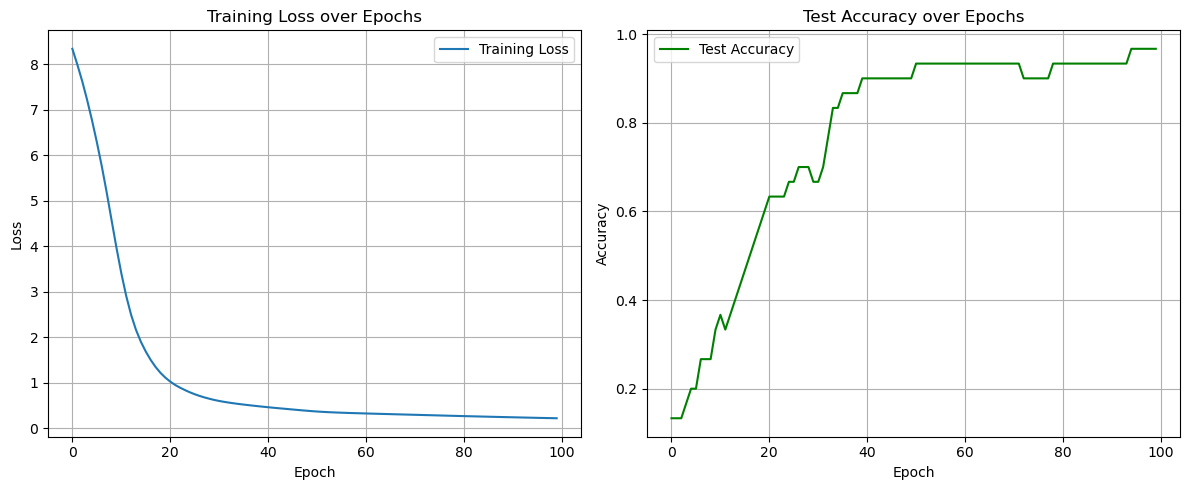

In [12]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_acc_history, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()